In [11]:
from itertools import combinations
from z3 import *
import math
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import random

In [12]:
def display_nqueens(sol):
    board = [[0] * len(sol) for i in range(len(sol))]
    for x, y in sol:
        board[x][y] = 1
    for i in range(len(board)):
        for j in range(len(board[0])):
            symbol = '♛' if board[i][j] == 1 else '.'
            print(symbol, end=' ')
        print()
def display_sudoku(sol):
    fig, ax = plt.subplots(figsize=(4, 4))
    for l in range(9):
        for c in range(9):
            v = sol[c][l]
            s = " "
            if v > 0:
                s = str(v)
            ax.text(l+0.5, 8.5-c, s, va='center', ha='center')
        ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_xticks(np.arange(9))
    ax.set_yticks(np.arange(9))
    ax.grid()
    plt.show()

In [13]:
def at_least_one(B):
    return Or(B)
def at_most_one_NAIVE(B, name=""):
    return And([Not(And(pair[0], pair[1])) for pair in combinations(B, 2)])
def exactly_one_NAIVE(bool_vars, name=""):
    return And(at_least_one(bool_vars), at_most_one_NAIVE(bool_vars))

In [14]:
def nqueens_sat(n):
    # Create all the variables
    p = [[Bool(f"x_{i}_{j}") for j in range(n)] for i in range(n)]

    # Create the solver instance
    s = Solver()

    # At least one on each row and column
    for i in range(n):
        s.add(at_least_one(p[i]))
        s.add(at_least_one([p[j][i] for j in range(n)]))

    # At most one on each row and column
    for i in range(n):
        col_i = []
        for j in range(n):
            col_i += [p[j][i]]
        s.add(at_most_one(p[i], f"row_{i}"))
        s.add(at_most_one(col_i, f"col_{i}"))

    # Add the diagonal constraints
    for i in range(n - 1):
        diag_ru = []
        diag_lu = []
        diag_rl = []
        diag_ll = []
        for j in range(n - i):
            diag_ru += [p[i + j][j]]
            diag_lu += [p[n - 1 - (i + j)][j]]
            diag_rl += [p[i + j][n - 1 - j]]
            diag_ll += [p[n - 1 - (i + j)][n - 1 - j]]
        s.add(at_most_one(diag_ru, f"diag_ru_{i}"))
        s.add(at_most_one(diag_lu, f"diag_lu_{i}"))
        s.add(at_most_one(diag_rl, f"diag_rl_{i}"))
        s.add(at_most_one(diag_ll, f"diag_ll_{i}"))

    s.check()

    m = s.model()
    return [(i, j) for i in range(n) for j in range(n) if m.evaluate(p[i][j])]

In [15]:
%%time
at_most_one = at_most_one_NAIVE
exactly_one = exactly_one_NAIVE
display_nqueens(nqueens_sat(6))

. . . . ♛ . 
. . ♛ . . . 
♛ . . . . . 
. . . . . ♛ 
. . . ♛ . . 
. ♛ . . . . 
Wall time: 283 ms


In [16]:
def at_most_one_COMMANDER(B, name="", m=None):
    # print('HI')
    n = len(B)
    
    if not m:
        g = 4
        m = math.ceil(n/g)
        base_case = n <= g
    else:
        g = math.ceil(n/m)
        base_case = n <= m
        
    if base_case:
        return at_most_one_NAIVE(B, name=name)
        
    Gs = []
    for i in range(m):
        if i!=m-1:
            Gs.append(B[g*i:g*(i+1)])
        else:
            Gs.append(B[g*i:])
        
    c = [Bool(f'c_{name}_{i}') for i in range(m)]
    
    formula1 = []
    for i in range(m):
        formula1.append(exactly_one_NAIVE(Gs[i] + [Not(c[i])], name=name))
    formula1 = And(formula1)
    
    # print(c)
    formula2 = at_most_one_COMMANDER(c, name=name+"_")
    
    return And(formula1, formula2)   

def exactly_one_COMMANDER(bool_vars, name=""):
    return And(at_least_one(bool_vars), at_most_one_COMMANDER(bool_vars, name=name))

In [17]:
%%time
at_most_one = at_most_one_COMMANDER
exactly_one = exactly_one_COMMANDER
display_nqueens(nqueens_sat(8))

. . . . . ♛ . . 
. . ♛ . . . . . 
. . . . . . ♛ . 
. . . ♛ . . . . 
♛ . . . . . . . 
. . . . . . . ♛ 
. ♛ . . . . . . 
. . . . ♛ . . . 
Wall time: 152 ms


In [18]:
%%time
at_most_one = at_most_one_COMMANDER
exactly_one = exactly_one_COMMANDER
display_nqueens(nqueens_sat(128))

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

. . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [19]:
# SEQUENTIAL ENCODING

def at_most_one_SEQUENTIAL(B, name):
    formulas_list = []
    n = len(B)  
    s = [Bool(f's_{name}_{i}') for i in range(n-1)]
    
    formulas_list.append( Or(Not(B[0]), s[0]) )
    formulas_list.append( Or(Not(B[n-1]), Not(s[n-2])) )

    for i in range(1, n-1):
        formula = And( Or(Not(B[i]),s[i]), Or(Not(s[i-1]),s[i]), Or(Not(B[i]),Not(s[i-1])) )
        formulas_list.append(formula)
        
    return And(formulas_list)

def exactly_one_SEQUENTIAL(bool_vars, name):
    return And(at_least_one(bool_vars), at_most_one_SEQUENTIAL(bool_vars, name=name))

In [20]:
%%time
at_most_one = at_most_one_SEQUENTIAL
exactly_one = exactly_one_SEQUENTIAL
display_nqueens(nqueens_sat(128))

KeyboardInterrupt: 

In [15]:
# Sudoku instances, '0's correspond to empty cells

instance = ((0, 0, 0, 0, 9, 4, 0, 3, 0),
            (0, 0, 0, 5, 1, 0, 0, 0, 7),
            (0, 8, 9, 0, 0, 0, 0, 4, 0),
            (0, 0, 0, 0, 0, 0, 2, 0, 8),
            (0, 6, 0, 2, 0, 1, 0, 5, 0),
            (1, 0, 2, 0, 0, 0, 0, 0, 0),
            (0, 7, 0, 0, 0, 0, 5, 2, 0),
            (9, 0, 0, 0, 6, 5, 0, 0, 0),
            (0, 4, 0, 9, 7, 0, 0, 0, 0))

In [16]:
def sudoku_sat(instance):
    # All the variables we need: for each cell, nine variables that determine which digit must be assigned.
    v = [[[Bool(f"v_{i}_{j}_{k}") for k in range(9)] for j in range(9)] for i in range(9)]

    s = Solver()

    # A cell has only one value
    for i in range(9):
        for j in range(9):
            s.add(exactly_one(v[i][j], f"valid_cell_{i}_{j}"))

    # Each value is used only once in a row
    for j in range(9):
        for k in range(9):
            s.add(exactly_one([v[i][j][k] for i in range(9)], f"valid_row_{j}_{k}"))

    # Each value used exactly once in each column
    for i in range(9):
        for k in range(9):
            s.add(exactly_one([v[i][j][k] for j in range(9)], f"valid_column_{i}_{k}"))

    # Each value used exactly once in each 3x3 grid.
    for ii in range(3):
        for jj in range(3):
            for k in range(9):
                grid_cells = [v[3 * ii + a][3 * jj + b][k] for a in range(3) for b in range(3)]
                s.add(exactly_one(grid_cells, f"valid_grid_{ii}_{jj}_{k}"))

    # Some numbers are already available
    for i in range(9):
        for j in range(9):
            if instance[i][j] > 0:
                s.add(v[i][j][instance[i][j] - 1])

    if s.check() == sat:
        m = s.model()
        sol = []
        for i in range(9):
            sol.append([])
            for j in range(9):
                for k in range(9):
                    if m.evaluate(v[i][j][k]):
                        sol[i].append(k+1)
        return sol
    else:
        print("Failed to solve")

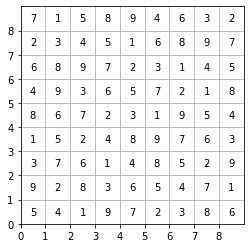

Wall time: 2.24 s


In [21]:
%%time
at_most_one = at_most_one_COMMANDER
exactly_one = exactly_one_COMMANDER
display_sudoku(sudoku_sat(instance))

In [23]:
def to_binary(n, length):
    n_binary = bin(n).split("b")[-1]
    if length:
        return "0"*(length - len(n_binary)) + n_binary
    return n_binary

def at_most_one_BIMANDER(B, name="", m=None):
    # print('HI')
    n = len(B)
    # m = 2
    
    if not m:
        g = 4
        m = math.ceil(n/g)
        #base_case = n <= g
    else:
        g = math.ceil(n/m)
        #base_case = n <= m
        
    #if base_case:
    #    return at_most_one_NAIVE(B, name=name)
        
    Gs = []
    for i in range(m):
        if i!=m-1:
            Gs.append(B[g*i:g*(i+1)])
        else:
            Gs.append(B[g*i:])
        
    #c = [Bool(f'c_{name}_{i}') for i in range(m)]
    r = math.ceil(math.log2(m))
    b = [Bool(f'b_{name}_{i}') for i in range(r)]
    
    formula1 = []
    for i in range(m):
        formula1.append(at_most_one_NAIVE(Gs[i], name=name))
    formula1 = And(formula1)
    
    # print(c)
    formula2 = []
    for i in range(m):
        binary_representation = to_binary(i, r)
        #print(binary_representation)
        for h in range(len(Gs[i])):  # g
            for j in range(r):
                #phi = b[j] if (binary_representation[j]=="1") else Not(b[j])
                formula2.append( Or(Not(Gs[i][h]),b[j] if (binary_representation[j]=="1") else Not(b[j])) )
    formula2 = And(formula2)
    
    return And(formula1, formula2)   

def exactly_one_BIMANDER(bool_vars, name=""):
    return And(at_least_one(bool_vars), at_most_one_BIMANDER(bool_vars, name=name))

In [24]:
%%time
at_most_one = at_most_one_BIMANDER
exactly_one = exactly_one_BIMANDER
display_nqueens(nqueens_sat(128))

. . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . .

. . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ .

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

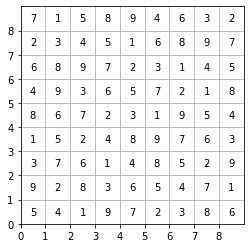

Wall time: 1.76 s


In [66]:
%%time
at_most_one = at_most_one_BIMANDER
exactly_one = exactly_one_BIMANDER
display_sudoku(sudoku_sat(instance))